In [135]:
import pandas as pd
from utils import GCSHelper
from preprocessing.basic_preprocessing import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from itertools import chain
from collections import Counter
import numpy as np

# 0. Import Data

In [2]:
gcshelper = GCSHelper('./keys/gcs_key.json')
gcshelper.download_file_from_gcs('csv/user_detail_total.csv', 'data/user_detail_total.csv')

In [3]:
data = pd.read_csv('./data/user_detail_total.csv')

# 1. 기본 전처리

In [4]:
# int로 나타낼 것을 나타내면서 exp 열 생성
data = get_int_basic(data)
# 기록이 없습니다. 인 것을 int (-1)로 나타냄
data = get_int_record(data)
# last access 꼴 통일
data['last_access'] = data['last_access'].apply(lambda x : x.replace('/', '-').replace('_', '-'))

In [5]:
data.columns

Index(['nickname', 'codi-hat', 'codi-hair', 'codi-face', 'codi-top',
       'codi-bottom', 'codi-shoes', 'codi-weapon', 'level', 'class',
       'popularity', 'total_ranking', 'world_ranking', 'class_world_ranking',
       'class_total_ranking', 'guild', 'last_access', 'mureung', 'theseed',
       'union', 'achievement', 'cur_chr', 'gcs_image_path', 'exp'],
      dtype='object')

# 2. Numeric 분포 확인

## 2-1. level

In [6]:
data['level'].describe()

count    1.317420e+06
mean     2.500174e+02
std      1.204625e+01
min      1.000000e+01
25%      2.400000e+02
50%      2.500000e+02
75%      2.560000e+02
max      2.930000e+02
Name: level, dtype: float64

In [7]:
# 레벨이랑 랭킹이 너무 낮은 유저들이 긁혀 있는데 이건 User_info와 detail을 크롤링하는 간격 사이에
# 닉네임을 변경했기 때문에 일어난 일으로 어쩔 수 없다는 결론
data[data['level']<200][['level', 'total_ranking']]

,level,total_ranking
572909,31,58245823
585504,100,44728819
587687,35,58090953
594250,196,14938306
617130,10,59598739
641086,181,54621879
736117,10,189459
775341,10,59518415
863521,31,57898632


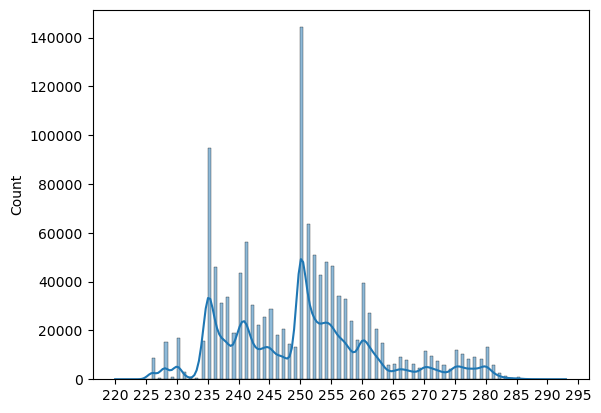

In [25]:
# 220 이상만 살펴보는 그래프 (그 이하는 이상치임)
level_cut = data[data['level']>=220]['level'].tolist()
level_plot = sns.histplot(level_cut, kde=True, binwidth=0.5)
level_plot.set_xticks(range(220,300,5))

<AxesSubplot: ylabel='Count'>

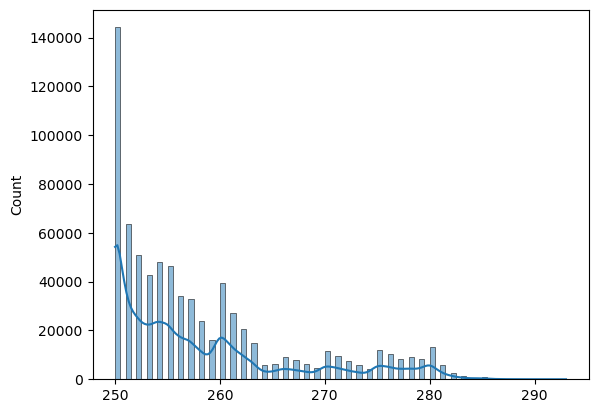

In [26]:
level_cut = data[data['level']>=250]['level'].tolist()
level_plot = sns.histplot(level_cut, kde=True, binwidth=0.5)
level_plot

- 225 언더는 데이터가 없기 때문에 확인할 수 없지만 235-240-245-250 까지는 5단위로 유저 수가 급증하는 것을 볼 수 있음
- 250에서 정점을 찍은 후 급락함 그 이후로도 5단위로 수가 증가하는 것을 확인할 수 있음

## 2-2. popularity

In [30]:
# popularity는 NA가 없던 column으로, 음수 -92167부터 99999까지 분포한다
data['popularity'].describe()

count    1.317420e+06
mean     2.349699e+02
std      1.663251e+03
min     -9.215700e+04
25%      2.000000e+00
50%      1.600000e+01
75%      1.000000e+02
max      9.999900e+04
Name: popularity, dtype: float64

<AxesSubplot: >

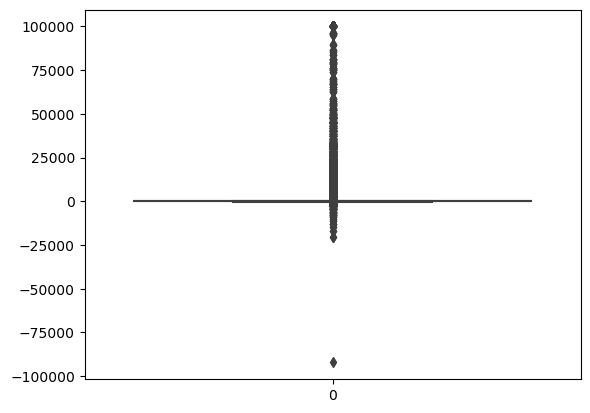

In [33]:
# 대부분 0 근처에서 분포함을 알 수 있음 (50%가 16, 75%가 100이니까)
# 음수인 유저들도 단 한명의 -92167 제외 -250000이상으로 분포함
# 이상치인 유저들 때문에 기이한 boxplot이 그려짐
sns.boxplot(data['popularity'])

<AxesSubplot: ylabel='Count'>

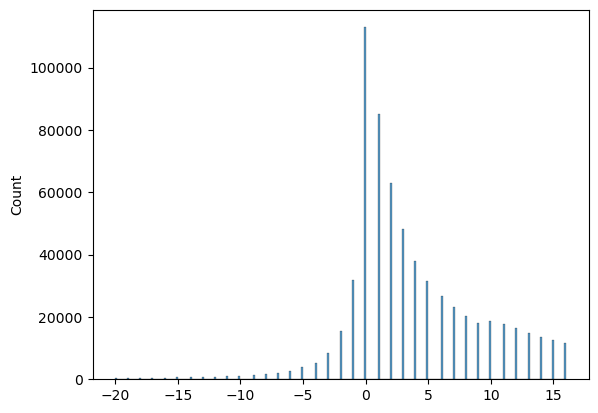

In [43]:
# Popularity의 최빈값은 0
data['popularity'].mode()

# 50%가 16이니까 16까지만 봐보자 (음수 이상치는 컷하고) => 좀 걸림
# 왜도하고 첨도가 엄청 큰 분포일 것 같음
pop_cut = data[(data['popularity']<=16)&(data['popularity']>=-20)]['popularity'].to_list()
sns.histplot(pop_cut)

In [46]:
# 실제로 왜도와 첨도 모두 엄청 큰 분포임
# 이걸 조정해줘야 하나? 어차피 쓸 것도 아니고 도메인 놀리지에 의해 인기도는 큰 신뢰도 없는 변수라고 하니 그냥 무시하겠음
skew(data['popularity']), kurtosis(data['popularity'])

(35.704632568915045, 1814.3702037535002)

## 2-3 ranking (total_ranking, world_ranking, class_world_ranking, class_total_ranking)

In [59]:
# 전체 랭킹이므로 절대 겹치지 않는 unique한 값일 것이라고 생각했으나 랭킹이 동일한 경우도 존재함
# 특히 375014의 경우 78번이나 등장하는데 살펴볼 필요가 존재함
data['total_ranking'].value_counts().head(10)

375014     78
1190515    13
26192      13
26624      13
7869        8
6607        8
180547      8
189050      8
4888        8
6697        8
Name: total_ranking, dtype: int64

In [72]:
# 랭킹이 같은 경우는 경험치가 소수점 첫째자리까지 동일하기 때문임
# 넥슨의 랭킹 설명에 의하면 캐릭터의 레벨, 경험치를 기준으로 하며 결과가 같을 경우, 달성한 시간 순으로 순위가 결정된다고 함
data[data['total_ranking']==375014]['exp'].value_counts(), data[data['total_ranking']==375014]['level'].value_counts() # 250
data[data['total_ranking']==1190515]['exp'].value_counts(), data[data['total_ranking']==1190515]['level'].value_counts() # 231

# 그러나 그 이하의 경우 경험치가 꽤 다른데도 같은 등수인데, 이를 좀 더 들여다 봐야겠음
data[data['total_ranking']==26192]['exp'].value_counts()
data[data['total_ranking']==7869]['exp'].value_counts()
data[data['total_ranking']==6607]['exp'].value_counts()
data[data['total_ranking']==180547]['exp'].value_counts()

# 26192등에는 3.936도 있는데 26191등에는 0.0이 존재하기도 함
# 왤까? 궁금하긴 하나 중요한 문제는 아니므로 넘어감
data[data['total_ranking']==26192]['exp'] #3.936, 0.0
data[data['total_ranking']==26191]['exp'] #3.944, 0.0
data[data['total_ranking']==26193]['exp'] #3.935

# 토탈 랭킹 제외 나머지는 중요하지 않다고 판단, 넘어가겠음

774119     3.944
1023453    0.000
Name: exp, dtype: float64

## 2-4. mureung

count    817449.000000
mean         45.877027
std           9.627109
min           1.000000
25%          42.000000
50%          47.000000
75%          50.000000
max          84.000000
Name: mureung, dtype: float64
49    70105
47    66545
46    61216
45    55196
48    54566
43    39203
38    37139
44    35771
42    35421
50    35404
51    31216
29    27424
41    24969
52    22333
40    19979
53    16435
54    14766
19    14744
55    14271
59    11545
Name: mureung, dtype: int64


<AxesSubplot: xlabel='mureung', ylabel='Count'>

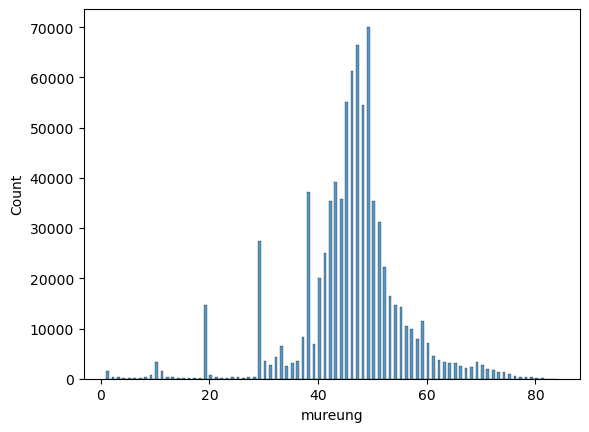

In [85]:
# mureung의 경우 '기록이 없습니다.'를 -1로 처리했음
# -1 즉 Null값의 비율은 0.3795
data['mureung'].value_counts()[-1]/len(data) # 0.37950767409026737

# -1을 제외한 나머지의 분포를 확인해보자
mureung_cut = data[data['mureung']!=-1]['mureung']

# 최저 1부터 시작하며 최대 84임 (평균이 45인데 25%~50%가 42~47에 존재하는 걸 보면 45근방에 많이 뭉쳐 있음)
print(mureung_cut.describe())

# 40~50 부근을 제외하면 메이플 레벨과 비슷하지만 또 다른 양상으로 49, 38, 29, 19, 처럼 10단위로 넘어가기 직전에 머무르는 유저가 많음
print(mureung_cut.value_counts().head(20))

sns.histplot(mureung_cut, binwidth=0.5)

- 갑자기 numeric 분포 보는거 지겨워지고 뭔 의민지 모르겠어서 관둠
- 추후 더 궁금해지면 다시 찾아와서 채워 넣겠음

# 3. codi 정보 파악
- 이름에 붙은 New는 일시적인게 아니고 영원히 붙어 있는 요소이다.
- 공백이 두개가 있는 경우가 존재한다.
- 이름에 숫자가 들어가 있는 경우가 존재한다. (ex 2010)
- 이름에 대괄호가 들어가 있는 경우가 존재한다. (ex \[BTS\])

In [88]:
# 이름의 오류를 파악하기 위해 글자를 다 쪼개서 확인해보는 함수
def get_sorted_set(column):
    item_list = list(chain(*list(data[column].str.split(' ').values)))
    item_set = Counter(item_list)
    item_set = sorted(item_set.items(), key=lambda kv:kv[1], reverse=True)
    return item_set

In [92]:
hat_set = get_sorted_set('codi-hat')
hair_set = get_sorted_set('codi-hair')
top_set = get_sorted_set('codi-top')
bottom_set = get_sorted_set('codi-bottom')
shoes_set = get_sorted_set('codi-shoes')
weapon_set = get_sorted_set('codi-weapon')

# face의 경우 #이 붙은 에러 데이터가 존재함 => 0.003이라서 무시해도 됨
face_set = get_sorted_set('codi-face')
data['codi-face'][data['codi-face'].str.find('#')!=-1].unique() # 22개
len(data['codi-face'][data['codi-face'].str.find('#')!=-1])/len(data) # 0.003이라서 무시해도 됨

0.0038598169148790816

#### NA 비율 확인

In [104]:
# null 값 비율 확인
# face의 경우 절반 이상이 NA고 bottom은 94%가 NA임
# 한벌 옷 때문이라는데 top에서 한벌 옷을 분리시켜줄 수 있나? -> bottom이 na+유저전체에 해당 상의에 하의를 입은 경우 X면 top을 한벌옷이라고 봐도 되지 않을까?
check_codi_null = lambda x : print(f"{x} :", len(data[f'codi-{x}'][data[f'codi-{x}']=='-'])/len(data))
check_codi_null('hat')
check_codi_null('hair')
check_codi_null('face')
check_codi_null('top')
check_codi_null('bottom')
check_codi_null('shoes')
check_codi_null('weapon')

hat : 0.10984424101653231
hair : 0.1998246572846928
face : 0.5834570600112341
top : 0.04092544518832263
bottom : 0.94659865494679
shoes : 0.28216438189795207
weapon : 0.11307631582942418


In [147]:
# 그렇다면 전부 NA인 유저가 있을까? 2380명
# 분명 하나만 있거나 두개만 있는 애들도 있을텐데 얘네를 어찌해줘야 할 지 모르겠네
data[(data['codi-hat']=='-')&(data['codi-hair']=='-')&(data['codi-face']=='-')&(data['codi-top']=='-')&(data['codi-bottom']=='-')&(data['codi-shoes']=='-')&(data['codi-weapon']=='-')]

,nickname,codi-hat,codi-hair,codi-face,codi-top,codi-bottom,codi-shoes,codi-weapon,level,class,...,class_total_ranking,guild,last_access,mureung,theseed,union,achievement,cur_chr,gcs_image_path,exp
2761,진쿠렁,-,-,-,-,-,-,-,238,카인,...,8906,DeoVolente,22-12-20,-1,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/진쿠렁/진쿠렁_22_12_20.png,64.490
2808,s율진나,-,-,-,-,-,-,-,238,나이트워커,...,13203,(없음),22-10-20,-1,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/s율진나/s율진나_22_12_20.png,64.293
5066,메인트로,-,-,-,-,-,-,-,238,카인,...,8944,(없음),21-05-23,49,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/메인트로/메인트로_22_12_20.png,57.051
5179,앴뱌,-,-,-,-,-,-,-,238,아델,...,80628,(없음),22-07-07,45,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/앴뱌/앴뱌_22_12_20.png,56.730
5767,단블e,-,-,-,-,-,-,-,238,듀얼블레이더,...,42281,(없음),22-03-03,49,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/단블e/단블e_22_12_20.png,54.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313779,DamKain,-,-,-,-,-,-,-,231,카인,...,17148,(없음),23-01-03,-1,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/DamKain/DamKain_23_01_03.png,0.187
1314508,카인강성윤,-,-,-,-,-,-,-,230,카인,...,17264,(없음),22-07-12,-1,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/카인강성윤/카인강성윤_22_07_12.png,85.073
1314602,너만혐사하냐,-,-,-,-,-,-,-,235,카인,...,13100,세상,23-01-09,-1,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/너만혐사하냐/너만혐사하냐_23_01_09.png,2.832
1315792,줏mang겜,-,-,-,-,-,-,-,230,팬텀,...,20608,(없음),22-03-07,-1,-1,-1,-1,https://avatar.maplestory.nexon.com/Character/...,image/user/줏mang겜/줏mang겜_22_03_07.png,82.700


#### 자주 입는 옷 조합 확인하기
- 전부 NA인 경우에는 삭제해줘야 함
- 대체로 세트를 입는 경향이 있음 (131만명 중 40만명만이 자기만의 코디를 함 (성형/헤어 제외)

In [129]:
# 성형/헤어 제외 자기만의 옷 조합으로 입고 있는 경우를 확인해보자 (131만명 중 91만명이 유니크하지 않은 코디를 입고 있음)
codi_df = data[['codi-hat', 'codi-top', 'codi-bottom', 'codi-shoes', 'codi-weapon']]
codi_duplicate = codi_df[codi_df.duplicated()]
print('all users and duplicate codi-ed users: ', len(data), len(codi_duplicate))

# df를 보면 아예 모든 정보가 Na인 유저들이 있음 -> 이런 경우는 삭제해줘야 할 것 같음 (이미지도 함께 삭제해야 하는거 유의)
# 츄츄아일랜드세트로 입고 있는 애들이 걍 엄청 많음
# 도메인 전문가 말로는 모두 세트라고 함 -> 유저들은 대부분 자기 만의 조합을 만들기 보다는 세트 옷을 입는 경향이 있어 보임
# 따라서 세트가 아닌 새로운 조합인데 어울리는 걸 추천해주려면 어떻게 해야 할까? 상관 없나.. 어차피 세트는 하나만 나올거고 그거 말고 다른 것도 순위권에 드니까
codi_duplicate_count = codi_duplicate.value_counts().to_frame()
codi_duplicate_count.head(30)

all users and duplicate codi-ed users:  1317420 911384


0
codi-hat      codi-top      codi-bottom codi-shoes     codi-weapon        
달달 머리띠        츄츄 카페 소년      -           새콤 슬리퍼         츄릅 매듭팔찌       82365
              츄츄 카페 소녀      -           새콤 슬리퍼         츄릅 매듭팔찌       64764
기억의 갈래        호수 물결         -           신기루 자욱         망각의 등불        21686
하이퍼 버닝 크라운    하이퍼 버닝 로브     -           -              하이퍼 버닝 소드     16573
-             -             -           -              -             15868
[BTS] 이클립스 페더 [BTS] 러브 인 스완 -           [BTS] 사일런트 나이트 [BTS] 라스트 페더   8246
흐드러진 악몽       아린 장미         -           악몽 무도곡         악몽 진주          7451
마이 퀸 티아라      페일 드림         -           속박의 매듭         악몽 시계          6840
시련의 무게        레이디 라비린스      -           해답의 조각         미궁의 연무         5937
영원 맹세         운명 집행관        -           떠도는 영원         운명의 데스티니       5518
시련의 무게        로드 라비린스       -           해답의 조각         미궁의 연무         5470
피어난 악몽        서린 장미         -           악몽 행진곡         악몽 진주          5188
별의 전언         꿈의 인도자        -           별빛 걸음          별의 전령          4835
하이퍼 버닝 크라운    하이퍼 버닝 로브     -           새콤 슬리퍼         하이퍼 버닝 소드      4811
어둠의 기사단모      어둠의 기사단복      -           어둠의 기사단화       어둠의 기사 표창      4654
별의 전언         꿈의 안내자        -           별빛 걸음          별의 전령          4285
신선 놀음 모자      신선 놀음 한벌옷     -           신선 놀음 신발       신선의 반딧불        4121
마이 퀸 티아라      엔들리스 드림       -           속박의 매듭         악몽 시계          3772
가려진 빛         화중신선          -           선녀의 자존심        천년의 약속         3722
하이퍼 버닝 크라운    하이퍼 버닝 로브     -           해와 달의 기사단화     하이퍼 버닝 소드      3464
영원 맹세         운명 심판관        -           머무른 영원         운명의 데스티니       3405
바람의 기사단모      바람의 기사단복      -           바람의 기사단화       바람의 기사 활       3359
미혹의 파편        그림자 영주        -           새벽 전진          여명의 빛          3315
흐드러진 악몽       서린 장미         -           악몽 행진곡         악몽 진주          3237
낙원의 증표        약속의 끝         -           이른 하교          피의 서약          3225
하이퍼 버닝 크라운    하이퍼 버닝 로브     -           바람의 기사단화       하이퍼 버닝 소드      3132
크로스 윙         판타스마 토트       -           블랙 포르테         죽음의 데스         3079
불의 기사단모       불의 기사단복       -           불의 기사단화        불의 기사 완드       2942
미드나잇 선글라스     미드나잇 캐주얼 셔츠   -           미드나잇 트윙클 스니커즈  미드나잇 코코넛 워터    2901
크로스 윙         판타스마 벨라       -           블랙 포르테         죽음의 데스         2750

### 아이템 별로 가장 많이 나온 아이템들을 살펴보자

In [238]:
# 이번엔 성형, 헤어까지 포함해보자
# 신기하게도 바지는 탑5가 모두 트릭스터라는 세트(?)로 부터 출발한 것을 확인할 수 있다.
# 확실히 애들이 바지는 많이 안 입는 것 같다.
codi_df = data[['codi-hat', 'codi-hair', 'codi-face', 'codi-top', 'codi-bottom', 'codi-shoes', 'codi-weapon']]
for column in codi_df.columns:
    print(codi_df[column].value_counts()[:10])
    print('-----------------------------------')

달달 머리띠           160319
-                144711
하이퍼 버닝 크라운        75092
기억의 갈래            23026
[BTS] 이클립스 페더     18382
시련의 무게            16604
토끼 귀              14612
흐드러진 악몽           12987
영원 맹세             12284
마이 퀸 티아라          11158
Name: codi-hat, dtype: int64
-----------------------------------
-           263253
아침등교 헤어      31026
포숑 헤어        30772
페르 헤어        24320
데미안 헤어       21924
신비 헤어        21637
루시드 헤어       21391
수호 헤어        21083
매직 엘라 헤어     20234
레드카펫 헤어      19219
Name: codi-hair, dtype: int64
-----------------------------------
-             768658
조용한 눈 얼굴      102408
멍한 얼굴          39073
차분한 헤헤 얼굴      36451
꼬맹이 얼굴         32581
루시드 얼굴         32424
도발적인 아잉 얼굴     17633
졸린 얼굴          16076
아잉 얼굴          16007
뾰로통 얼굴         10439
Name: codi-face, dtype: int64
-----------------------------------
츄츄 카페 소년         91044
하이퍼 버닝 로브        74088
츄츄 카페 소녀         71025
-                53916
[BTS] 러브 인 스완    36723
호수 물결            23144
핑크빈 후디           16371
특대

#### 레벨에 따른 옷 경향성이 있나 확인해보자
- 세트를 입으면 능력치를 올려주기 때문에 세트는 코디로서의 의미보다는 전투복의 느낌이 있다고 한다.
- 또한 고레벨인 경우 강해져야 하니까 강제적으로 세트를 입게 되는 경향이 있다고 한다.
- 따라서 저레벨인 경우 세트를 입는 경향성이 고레벨의 경우 보다 덜한지 확인해보자.

In [143]:
# 우리 데이터는 애초에 225까지 밖에 긁어오지 않았기 때문에 전체 메이플 유저에 비하면 고레벨 쪽에 속해 있다.
# 하지만 그 안에서의 경향성을 확인해 보도록 하자
# 참고로 이때도 hair, face는 제외한다 -> 세트로 주어지긴 하지만 세트 '효과'를 안 주므로 끼는 건 본인의 의지이기 때문이다
level_high = np.quantile(data['level'], .75)
level_mid = np.quantile(data['level'], .50)
level_low = np.quantile(data['level'], .25)

codi_df['level'] = data['level']
codi_high = codi_df[codi_df['level']>=level_high].drop(['level', 'codi-hair', 'codi-face'], axis=1)
codi_mid_h = codi_df[(codi_df['level']>=level_mid)&(codi_df['level']<level_high)].drop(['level', 'codi-hair', 'codi-face'], axis=1)
codi_mid_l = codi_df[(codi_df['level']>=level_low)&(codi_df['level']<level_mid)].drop(['level', 'codi-hair', 'codi-face'], axis=1)
codi_low = codi_df[codi_df['level']<level_low].drop(['level', 'codi-hair', 'codi-face'], axis=1)
print(len(codi_high), len(codi_mid_h), len(codi_mid_l), len(codi_low)) # 대강 비슷하게 나눠졌음

/tmp/ipykernel_34346/3649792247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codi_df['level'] = data['level']


360707 395824 273501 287388


In [164]:
# 의외로 고레벨인 유저들이 더욱 유니크하게 코디를 한다고 볼 수 있음 (우리 데이터만 봐선)
print('Only one-------------------------------------')
unique_codi_rate = lambda x : print(f'x의 Unique 코디 비율: ', sum(x[x.duplicated()].value_counts().to_frame().reset_index(drop=False)[0]==1) / len(x))
unique_codi_rate(codi_high)
unique_codi_rate(codi_mid_h)
unique_codi_rate(codi_mid_l)
unique_codi_rate(codi_low)
print('Under 10-------------------------------------')
unique_codi_rate = lambda x : print(f'x의 Unique 코디 비율: ', sum(x[x.duplicated()].value_counts().to_frame().reset_index(drop=False)[0]<=10) / len(x))
unique_codi_rate(codi_high)
unique_codi_rate(codi_mid_h)
unique_codi_rate(codi_mid_l)
unique_codi_rate(codi_low)

Only one-------------------------------------
x의 Unique 코디 비율:  0.12667344964195315
x의 Unique 코디 비율:  0.12834997372569626
x의 Unique 코디 비율:  0.035312485146306596
x의 Unique 코디 비율:  0.05014475204253483
Under 10-------------------------------------
x의 Unique 코디 비율:  0.17277180648005167
x의 Unique 코디 비율:  0.1803453049840333
x의 Unique 코디 비율:  0.05608754629781975
x의 Unique 코디 비율:  0.07099809317020891


In [165]:
# 성형과 헤어까지 포함한다면 비율이 좀 늘어나겠지?
# 놀랍게도 성형/헤어를 포함했음에도 불구하고 상대적 저레벨 유저들의 유니크 코디 비율은 늘어나지 않았음
# 반면 상대적 고레벨 유저들의 유니크 비율은 꽤 높아졌는데, 이는 비슷한 코디를 하고 있더라도 성형/헤어로 자기만의 개성을 표현한 유저들이 많다고 해석해 볼 수 있음
# 즉 성형/헤어가 유저에게 자신의 아이덴티티를 표현함에 있어 중요한 요소임
# 시퀀스를 확인해봤다면 유저가 다른 옷에 비해 성형/헤어를 잘 안 바꾼다는 데이터를 볼 수 있었을 것 같은데 안타깝게도 없으므로 패스하자
codi_high = codi_df[codi_df['level']>=level_high].drop(['level'], axis=1)
codi_mid_h = codi_df[(codi_df['level']>=level_mid)&(codi_df['level']<level_high)].drop(['level'], axis=1)
codi_mid_l = codi_df[(codi_df['level']>=level_low)&(codi_df['level']<level_mid)].drop(['level'], axis=1)
codi_low = codi_df[codi_df['level']<level_low].drop(['level'], axis=1)
print('Only one-------------------------------------')
unique_codi_rate = lambda x : print(f'x의 Unique 코디 비율: ', sum(x[x.duplicated()].value_counts().to_frame().reset_index(drop=False)[0]==1) / len(x))
unique_codi_rate(codi_high)
unique_codi_rate(codi_mid_h)
unique_codi_rate(codi_mid_l)
unique_codi_rate(codi_low)
print('Under 10-------------------------------------')
unique_codi_rate = lambda x : print(f'x의 Unique 코디 비율: ', sum(x[x.duplicated()].value_counts().to_frame().reset_index(drop=False)[0]<=10) / len(x))
unique_codi_rate(codi_high)
unique_codi_rate(codi_mid_h)
unique_codi_rate(codi_mid_l)
unique_codi_rate(codi_low)

Only one-------------------------------------
x의 Unique 코디 비율:  0.17485937339724486
x의 Unique 코디 비율:  0.19814614576175268
x의 Unique 코디 비율:  0.03836914673072493
x의 Unique 코디 비율:  0.06395534956226426
Under 10-------------------------------------
x의 Unique 코디 비율:  0.22034781692620325
x의 Unique 코디 비율:  0.25636646590403817
x의 Unique 코디 비율:  0.05772922219662817
x의 Unique 코디 비율:  0.08532367391818726


# 4. last_access
- NA의 경우 '-'

(array([  9212.,  52867., 325056., 173734., 429878., 175028.,  61108.,
         57192.,  32829.,    496.]),
 array([220. , 227.3, 234.6, 241.9, 249.2, 256.5, 263.8, 271.1, 278.4,
        285.7, 293. ]),
 <BarContainer object of 10 artists>)

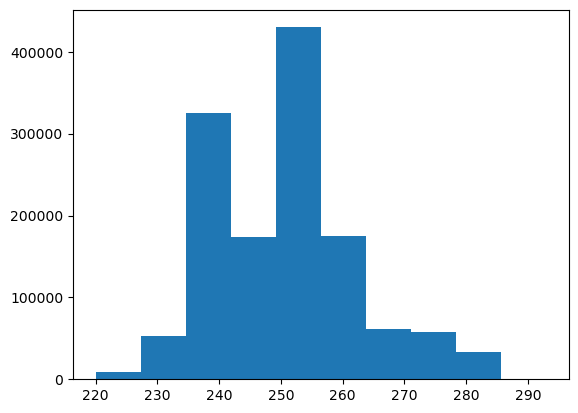

In [179]:
plt.hist(data[data['level']>=220]['level'].to_list())

/tmp/ipykernel_34346/4036620881.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l, ax=ax)
/tmp/ipykernel_34346/4036620881.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l, ax=ax)


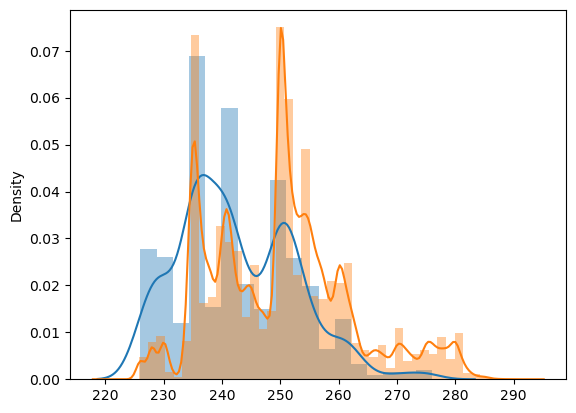

In [198]:
# NA 비율: 0.0008364834297338738로 별로 없음
len(data[data['last_access']=='-']) / len(data)
# level에 따른 NA 경향성이 있는지 확인해볼것
# 고레벨 보다 저레벨 쪽에서 NA가 많음 -> 특정 날짜 이전은 -로 취급하는게 아닐까?
la_na = data[data['last_access']=='-'][['level', 'last_access']]
fig, ax = plt.subplots()
for l in [la_na['level'].to_list(), data[data['level']>=220]['level'].to_list()]:
    sns.distplot(l, ax=ax)

In [229]:
# 25%까지가 2022년에 하반기일정도로 액티브 유저가 많은 걸 확인 할 수 있음
last_access_level = data[['level', 'last_access']]
last_access_level = last_access_level[last_access_level['last_access']!='-']
last_access_level['last_access'] = pd.to_datetime(last_access_level['last_access'], format='%y-%m-%d')
last_access_level['last_access'].describe(datetime_is_numeric=True)

count                          1316318
mean     2022-10-04 10:54:46.815496192
min                2018-10-19 00:00:00
25%                2022-09-16 00:00:00
50%                2022-12-14 00:00:00
75%                2022-12-21 00:00:00
max                2023-01-12 00:00:00
Name: last_access, dtype: object

<AxesSubplot: xlabel='last_access', ylabel='Count'>

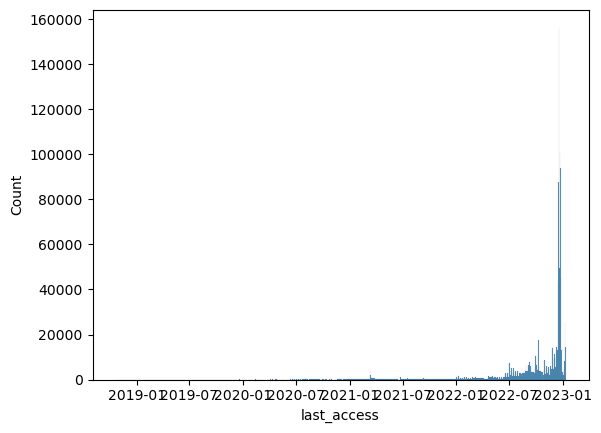

In [236]:
# 전체를 봐보자 -> 크롤링 한 날짜 근방에 몰려 았는 것은 당연함
sns.histplot(last_access_level['last_access'])